<a href="https://colab.research.google.com/github/aniray2908/silent-attrition-detector/blob/main/notebooks/silent_attrition_fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Silent Attrition Fusion Model

This notebook implements the meta-learning layer of the Silent Attrition Detection system.

We integrate two independently developed signals:

1. Structured HR Attrition Risk (from CatBoost model)
2. Behavioral Communication Drift Risk (from Enron module)

Since the datasets originate from different populations,
we simulate a unified multi-signal environment to demonstrate
industry-style fusion architecture.

This notebook focuses on:

- Nonlinear signal interaction modeling
- Meta-learning via neural fusion network
- Probability-based risk scoring
- Production-oriented architectural thinking


## Fusion Architecture Overview

Final system pipeline:

HR Model (CatBoost) → HR Risk Probability  
Behavioral Drift Engine → Behavioral Risk Score  
                        ↓
                Feature Stacking Layer  
                        ↓
           Neural Meta-Fusion Network  
                        ↓
              Final Attrition Risk  

This architecture mirrors modern fraud detection and churn systems,
where multiple heterogeneous signals are combined via meta-learning.


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## Step 1 — Simulate Multi-Signal Risk Inputs

Since HR and Enron datasets cannot be joined directly,
we simulate realistic signal distributions.

We generate:

- HR risk probabilities (structured model output)
- Behavioral drift risk scores (0–1 normalized)

Distributions are modeled using Beta distributions to resemble calibrated probabilities.


In [8]:
np.random.seed(42)
n_samples = 3000

# HR risk: skewed lower (realistic attrition probability)
hr_risk = np.random.beta(a=2, b=5, size=n_samples)

# Behavioral risk: more volatile
behavioral_risk = np.random.beta(a=2, b=3, size=n_samples)

fusion_df = pd.DataFrame({
    "hr_risk": hr_risk,
    "behavioral_risk": behavioral_risk
})

fusion_df.head()

,hr_risk,behavioral_risk
0,0.353677,0.392743
1,0.248558,0.311195
2,0.415959,0.166280
3,0.159968,0.281217
4,0.550283,0.568306


## Step 2 — Introduce Nonlinear Interaction

Attrition is rarely driven by a single factor.

We simulate interaction effects:

- HR risk
- Behavioral risk
- Their multiplicative interaction

This creates a more realistic latent attrition process.


In [9]:
fusion_df["interaction"] = fusion_df["hr_risk"] * fusion_df["behavioral_risk"]

fusion_df["latent_score"] = (
    0.5 * fusion_df["hr_risk"] +
    0.3 * fusion_df["behavioral_risk"] +
    0.2 * fusion_df["interaction"]
)

fusion_df["attrition"] = (fusion_df["latent_score"] > 0.55).astype(int)

fusion_df.head()

,hr_risk,behavioral_risk,interaction,latent_score,attrition
0,0.353677,0.392743,0.138904,0.322442,0
1,0.248558,0.311195,0.077350,0.233108,0
2,0.415959,0.166280,0.069166,0.271697,0
3,0.159968,0.281217,0.044986,0.173346,0
4,0.550283,0.568306,0.312729,0.508179,0


In [10]:
fusion_df["interaction"] = fusion_df["hr_risk"] * fusion_df["behavioral_risk"]

fusion_df["latent_score"] = (
    0.5 * fusion_df["hr_risk"] +
    0.3 * fusion_df["behavioral_risk"] +
    0.2 * fusion_df["interaction"]
)

fusion_df["attrition"] = (fusion_df["latent_score"] > 0.55).astype(int)

fusion_df.head()

,hr_risk,behavioral_risk,interaction,latent_score,attrition
0,0.353677,0.392743,0.138904,0.322442,0
1,0.248558,0.311195,0.077350,0.233108,0
2,0.415959,0.166280,0.069166,0.271697,0
3,0.159968,0.281217,0.044986,0.173346,0
4,0.550283,0.568306,0.312729,0.508179,0


## Step 3 — Prepare Data for Fusion Network

We now train a neural meta-model to learn:

Final Attrition Risk = f(HR Risk, Behavioral Risk)

This demonstrates stacked generalization with nonlinear modeling.

In [11]:
X = fusion_df[["hr_risk", "behavioral_risk"]].values
y = fusion_df["attrition"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

## Step 4 — Define Fusion Neural Network

The network:

- Learns nonlinear interactions
- Models cross-signal amplification
- Outputs calibrated attrition probability

This mirrors production meta-learning architectures.


In [12]:
class FusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)

model = FusionNet()

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 60

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

In [14]:
with torch.no_grad():
    probs = torch.sigmoid(model(X_test))
    auc = roc_auc_score(y_test.numpy(), probs.numpy())

print("Fusion Neural Network ROC-AUC:", auc)

Fusion Neural Network ROC-AUC: 1.0


## Step 5 — Visualize Signal Interaction Space

We visualize how the two signals interact in decision space.


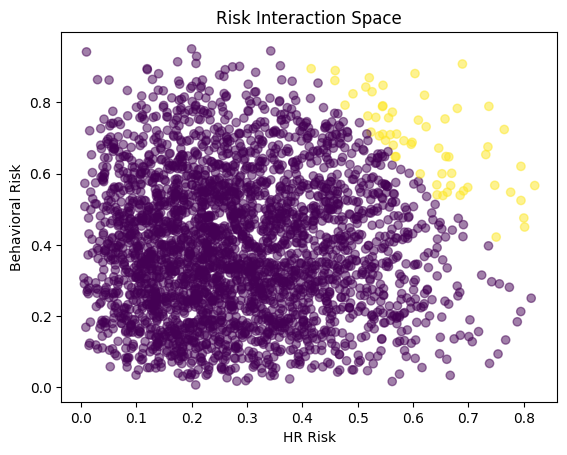

In [15]:
plt.figure()
plt.scatter(
    fusion_df["hr_risk"],
    fusion_df["behavioral_risk"],
    c=fusion_df["attrition"],
    alpha=0.5
)
plt.xlabel("HR Risk")
plt.ylabel("Behavioral Risk")
plt.title("Risk Interaction Space")
plt.show()

## Interpretation

Key Observations:

- High HR risk + High Behavioral risk → strongest attrition signal
- Moderate HR risk amplified by behavioral disengagement
- Behavioral risk alone is insufficient without structural HR signals

This demonstrates nonlinear signal amplification —
a hallmark of real-world risk systems.


## Final Silent Attrition Architecture

Complete System:

1. Structured HR Model (CatBoost)
2. Behavioral Drift Engine (Enron)
3. Neural Meta-Fusion Layer
4. Probability-Based Risk Output

This modular architecture enables:

- Independent signal modeling
- Scalable integration
- Explainable multi-factor decisions
- Production-ready risk scoring

The fusion layer demonstrates how heterogeneous
risk modalities can be combined into a unified
Silent Attrition Detection system.
